In [1]:
!pip install wandb

     |████████████████████████████████| 1.4MB 4.6MB/s 
     |████████████████████████████████| 102kB 11.1MB/s 
     |████████████████████████████████| 460kB 27.1MB/s 
     |████████████████████████████████| 102kB 10.1MB/s 
     |████████████████████████████████| 112kB 24.2MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=383136bb7f8bb1599c5c59aa211683429b85defef458a0f1f199caa1c55a0b13
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73870 sha256=f8296ae9a505875488aa165300ecb9151c67532e4d2dd1b5c0920f482333e32a
  Stored in directory: /root/.cache/pip/wheels/a8/1d/38/2c19bb311f67cc7b4d07a2ec5ea36ab1a0a0ea50db994a5bc7
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=8

In [2]:
!wandb login

wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: dff003aa03e7d25df35a840b6f0660ae9675efb4
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [3]:
#launch in colab
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
#GPU INFO
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jul  7 19:43:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import sys
#launch in colab
sys.path.append('/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101')


In [6]:
# Internal files
import config
import dataloader
import models

# Pytorch libraries
import torch
import torch.backends.cudnn as cudnn

import os
import time

import wandb


noise file /content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/data/noisy_label_kv30_sim.txt generated with noise: 0.3



In [7]:
import numpy as np
import random

random.seed(0)
np.random.seed(0)

import pandas as pd
if config.noise_validation == True:
        df_labels = pd.read_csv(config.drive_dir+"/data/" + "clean_label_kv.txt", header = None, sep = " ")
        df_labels.columns = ["dir", "clean_label"]
    
        df_val = pd.read_csv(config.drive_dir+"/data/clean_val_key_list.txt", header = None, sep = " ")
        df_val.columns = ["dir"]
    
        df_val = df_val.merge(df_labels, how = 'left', left_on = "dir", right_on = "dir")


        #generate a list of random labels
        randomlist = []
        set_classes = set(df_val.clean_label)
        for i in range(0,df_val.shape[0]):
            n = random.randint(min(set_classes),max(set_classes))
            randomlist.append(n)
        df_val["random_class"] = randomlist
    
        #column of probabilities (uniform)
        df_val["p"] = np.random.uniform(0,1,df_val.shape[0])
    
        #use the random list to generate noise in effective percentage r
        N_CLASSES = len(set_classes)
        NOISE_PERCENTAGE = config.r*N_CLASSES/(N_CLASSES-1)
        noisy_class = []
        for index, row in df_val.iterrows():
            if row["p"]<= NOISE_PERCENTAGE:
                noisy_class.append( row["random_class"])
            else:
                noisy_class.append(row["clean_label"])
    
        df_val["noisy_class"] = noisy_class
    
        df_labels["noisy_class"] = df_labels["clean_label"]
        df_val_relabeled = df_val[["dir","noisy_class"]].copy()


        #read noisy labels
        df_labels = pd.read_csv(config.drive_dir+"/data/" + config.train_labels_file, header = None, sep = " ")
        df_labels.columns = ["dir", "noisy_class"]
        df_val = pd.read_csv(config.drive_dir+"/data/clean_val_key_list.txt", header = None, sep = " ")
        df_val.columns = ["dir"]
        val_list = list(df_val.dir)
        def is_validation(x):
          if (x in val_list):
            return(1)
          return(0)

        #separate noisy train and clean test from validation
        df_test = pd.read_csv(config.drive_dir+"/data/clean_test_key_list.txt", header = None, sep = " ")
        df_test.columns = ["dir"]
        test_list = list(df_test.dir)
        test_list = ['/images/' + x + '.jpg' for x in test_list]
        def is_test(x):
          if (x in test_list):
            return(1)
          return(0)
        df_labels.drop_duplicates(subset='dir', keep="last",  inplace = True)
        df_labels["validation_set"] = [is_validation(x) for x in df_labels.dir]
        df_labels["test_set"] =       [is_test(x) for x in df_labels.dir]
        df_labels["train_set"] = (df_labels["test_set"] + df_labels["validation_set"])*(-1) + 1


        train = df_labels[(df_labels.train_set == 1)  ].copy()
        test  = df_labels[(df_labels.test_set == 1)  ].copy()
        #get unique train
        #get unique test

        #Join noisy validation with previous labels
        df_full = df_val_relabeled.append(test[["dir","noisy_class"]]).append(train[["dir","noisy_class"]])
    
        #export
        filename = config.drive_dir + '/data/' + 'noisy_label_kv'+str(int(config.r*100))+'_sim.txt'
        df_full["noisy_class"] = [int(x) for x in df_full["noisy_class"]]
        df_full[["dir", "noisy_class"]].to_csv(filename, sep=' ', index=False,header = False)
        print("\nnoise file " + filename + " generated with noise: " + str(config.r)+"\n")
        # return(df_train[["directory", "noisy_class"]])
       
        test_validation_labels_file  = 'noisy_label_kv'+str(int(config.r*100))+'_sim.txt'

        df_full


noise file /content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/data/noisy_label_kv30_sim.txt generated with noise: 0.3



In [8]:
def get_model():

    # Get model from config
    if config.model == "resnet18":
        model = models.resnet18(pretrained=config.pretrained)
    elif config.model == "resnet34":
        model = models.resnet34(pretrained=config.pretrained)
    elif config.model == 'resnet50':
        model = models.resnet50(pretrained=config.pretrained)
    elif config.model == "resnet101":
        model = models.resnet101(pretrained=config.pretrained)
    elif config.model == "resnet152":
        model = models.resnet152(pretrained=config.pretrained)
    elif config.model == "resnext50_32x4d":
        model = models.resnet34(pretrained=config.pretrained)
    elif config.model == 'resnext101_32x8d':
        model = models.resnet50(pretrained=config.pretrained)
    elif config.model == "wide_resnet50_2":
        model = models.resnet101(pretrained=config.pretrained)
    elif config.model == "wide_resnet101_2":
        model = models.resnet152(pretrained=config.pretrained)
    else:
        raise ValueError('%s not supported'.format(config.model))

    # Initialize fc layer
    (in_features, out_features) = model.fc.in_features, model.fc.out_features
    model.fc = torch.nn.Linear(in_features, out_features)
    return model


def scheduler(epoch):
    global lr
    lr = config.lr
    if epoch > config.start_epoch:
        lr = lr / 10.0
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if config.use_wandb == True:
        wandb.save(filename)

def save_weights(epoch):
        print('| Saving Weights ...', end="\r")
        save_point = config.drive_dir + '/checkpoint/' + config.checkpoint + '_' + str(epoch) + '.pth.tar'
        save_checkpoint({'state_dict': net.state_dict(), }, save_point)

In [14]:
# Training
def train(epoch):
  net.train()
  train_loss = 0
  correct = 0
  total = 0
  scheduler(epoch)

  # print("train before dataloader")
  for step, (inputs, targets, path) in enumerate(train_loader):
      init_time = time.time()
      if use_cuda:  # GPU settings
          (inputs, targets) = inputs.cuda(), targets.cuda()
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      train_loss += loss.data.item()
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += predicted.eq(targets.data).cpu().sum()

      # Grab training results
      # print("| Epoch: {}/{}, step: {}/{}, loss: {:.3f}, acc: {:.3f}, time: {:.3f}".format(epoch,config.num_epochs,step + 1,len(train_loader.dataset),loss.data.item(),100. * correct / total,time.time() - init_time))
      # print("| Epoch: {}/{}, step: {}/{}, loss: {:.3f}, acc: {:.3f}, time: {:.3f}".format(epoch,config.num_epochs,step + 1,len(train_loader.dataset),loss.data.item(),100. * correct / total,time.time() - init_time),end="\r")

      sys.stdout.write('\r')
      sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%, time: %.3f'
              %(epoch, config.num_epochs, step+1, (len(train_loader.dataset)//config.batch_size)+1, loss.data.item(), 100.*correct/total,time.time() - init_time))
      sys.stdout.flush()

def valid(epoch):
    global best_acc
    net.eval()
    # valid_loss = 0
    correct = 0
    total = 0
    for step, (inputs, targets, path) in enumerate(valid_loader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            # valid_loss += loss.data.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

    # Grab validation results
    valid_acc = 100. * correct / total
    valid_results = ("| Epoch: {}/{}, val_loss: {:.3f}, val_acc: {:.3f}, ""lr: {:.6f}".format(epoch,config.num_epochs,loss.data.item(),valid_acc,lr))
    record.write(valid_results + '\n')
    record.flush()

    if config.use_wandb == True:
        wandb.log({'epoch': epoch, 'accy_val' : valid_acc })

    # Save checkpoint when best model
    if valid_acc > best_acc:
        best_acc = valid_acc
        print('| Saving Best Model ...', end="\r")
        save_point = config.drive_dir + '/checkpoint/' + str(config.checkpoint) + '.pth.tar'
        save_checkpoint({'state_dict': net.state_dict(), }, save_point)



def test():
    test_net.eval()
    # test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets, path) in enumerate(valid_loader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = test_net(inputs)
            loss = criterion(outputs, targets)

        # test_loss += loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    # Grab validation results
    test_acc = 100. * correct/total
    test_results = "| test_loss: {:.3f}, test_acc: {:.3f}".format(
        loss.data.item(), test_acc)
    record.write(test_results)
    record.flush()

    print(test_results)
    wandb.log({'test_acc' : test_acc })

In [15]:
record = open(config.drive_dir + '/checkpoint/' + config.checkpoint + '_test.txt', 'w')
# record.write('noise_rate=%s\n' % config.noise_rate)
record.flush()



In [16]:
# Get the original_dataset
loader = dataloader.KeyDataLoader()
train_loader, valid_loader, test_loader = loader.run()

# Hyper Parameter settings
torch.manual_seed(config.seed)
torch.cuda.manual_seed_all(config.seed)
use_cuda = torch.cuda.is_available()

# Networks setup
print('\nModel setup')
print('| Building network: {}'.format(config.model))
net = get_model()
test_net = get_model()

if use_cuda:
    net.cuda()
    test_net.cuda()
    cudnn.benchmark = True

# Instantiate a loss function.
criterion = torch.nn.CrossEntropyLoss()

# Instantiate an optimizer to train the model.
optimizer = torch.optim.SGD(
    net.parameters(), lr=config.lr, momentum=0.9, weight_decay=0.001)

print('\nTraining model')
print('| Training Epochs = ' + str(config.num_epochs))
print('| Initial Learning Rate = ' + str(config.lr))
print('| Optimizer = ' + str(config.optimizer_type))



Model setup
| Building network: resnet50


/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/models/resnet.py:116: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight, mode='fan_out')
/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/models/resnet.py:118: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.weight, 1)
/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/models/resnet.py:119: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)



Training model
| Training Epochs = 5
| Initial Learning Rate = 0.008
| Optimizer = SGD


In [17]:
# config.num_epochs = 30

In [18]:
#Train
best_acc = 0
for epoch in range(1, 1 + config.num_epochs):
    train(epoch)
    valid(epoch)
    save_weights(epoch)

In [19]:
print('\nTesting model')

checkpoint = torch.load(config.drive_dir + '/checkpoint/' + config.checkpoint + '.pth.tar')
test_net.load_state_dict(checkpoint['state_dict'])
test()


Testing model
| test_loss: 0.530, test_acc: 72.158


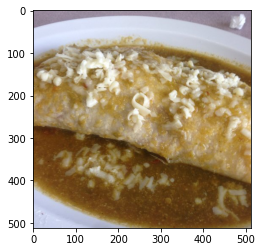

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

im = np.array(Image.open('/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/data/images/breakfast_burrito/3100854.jpg'))
plt.imshow(im)
plt.show()

In [21]:
def TEST():
    test_net.eval()
    # test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets, path) in enumerate(test_loader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = test_net(inputs)
            loss = criterion(outputs, targets)

        # test_loss += loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    # Grab validation results
    test_acc = 100. * correct/total
    test_results = "| test_loss: {:.3f}, test_acc: {:.3f}".format(
        loss.data.item(), test_acc)
    record.write(test_results)
    record.flush()

    print(test_results)
    wandb.log({'test_acc' : test_acc })

In [22]:
TEST()

| test_loss: 0.533, test_acc: 77.457
